# Uncapacitated Facility Location Problem

In [106]:
# import
from pulp import *
from solver_utils import *
from data_utils import *
import numpy as np
import matplotlib as plot
plot.rcParams['figure.figsize'] = [10, 5]
import seaborn

# services
Data = DataGenerator()
Log = DataLogger()

## Primal Model

In [107]:
def build_primal(c_num, l_num, C, F):
    # problem instance
    problem = LpProblem("UFL - Primal Problem (Wolsey)", sense=LpMaximize)

    # decision variables
    x = Data.VAR_matrix(c_num, l_num, 'x', 'Binary')
    y = Data.VAR_vector(l_num, 'y', 'Binary')

    # objective function
    service_costs = [C[i][j] * x[i][j] for i in range(c_num) for j in range(l_num)]
    fixed_costs = [F[j] * y[j] for j in range(l_num)]
    problem += lpSum(service_costs) - lpSum(fixed_costs), "Total Costs"

    # constraints
    for i in range(c_num):
        problem += lpSum([x[i][j] for j in range(l_num)]) == 1

    for i in range(c_num):
        for j in range(l_num):
            problem += x[i][j] - y[j] <= 0
            
    return problem

## Relaxed Model

In [108]:
def build_relaxed(c_num, l_num, u_vector, C, F):
    """
    Lagrange relaxation for UFL problem as in Wolsey
    """

    # problem instance
    problem = LpProblem("UFL - Lagrange Relaxed Problem (Wolsey)", sense=LpMaximize)

    # check lagrange multipliers vector
    if len(u_vector) != c_num : 
        raise ValueError('Invalid u_vect size')

    # decision variables    
    x = Data.VAR_matrix(c_num, l_num, 'x', 'Binary')
    y = Data.VAR_vector(l_num, 'y', 'Binary')

    # objective function
    s_c = [(C[i][j] - u_vector[i]) * x[i][j] for i in range(c_num) for j in range(l_num)]
    f_c = [F[j] * y[j] for j in range(l_num)]
    u_c = [u_vector[i] for i in range(c_num)]

    problem += lpSum(s_c) - lpSum(f_c) + lpSum(u_c)

    # constraints
    for i in range(c_num):
        for j in range(l_num):
            problem += x[i][j] - y[j] <= 0

    return problem

## Subgradient algorithm

In [109]:
def run_subgradient(c_num, l_num, u_vector, z_ip, C, F):
    # parameters
    t_max = 10 # maximum loops w/ improvement
    k = 1 # no improvement loop counter
    alpha_stop = 0.05 # stop parameter
    alpha = 10
    z_best = np.Infinity 

    while True:
        # compute best z(u)
        p_lr = build_relaxed(c_num, l_num, u_vector, C, F)
        solve(p_lr)
        z_lr = get_objectiveFunction_value(p_lr)
        Log.logData('z_lr', z_lr)
        Log.logData('z_ip', z_ip) # simplify plotting

        # compute subgradient
        x_lr = get_variable_value(p_lr, 'x')
        sg = subgradient_tbn(x_lr, c_num, l_num)

        # check subgradient
        if not np.any(sg):
            break

        # compute step size            
        step = step_tbn(alpha, z_ip, z_lr, sg)
        Log.logData('step_size', step)

        # compute new lagrange multipliers
        u = u_vector #copy
        u_vector = update_lagrange_tbn(u, step, sg)

        # check bound
        if z_lr < z_best:
            z_best = z_lr
            k = 0
            print(f"z_best: {z_best}")
        else:
            k = k+1

        # check counter
        if k == t_max:
            alpha = alpha / 2
            k = 0
            print(f"alpha: {alpha}")

        # check stop condition
        if alpha < alpha_stop:
            break
    
    print(f"subgradient method result: {z_best}")
    return z_best

### Compute subgradient vector

In [110]:
def subgradient_tbn(x_lr, c_num, l_num):
    # reshape X matrix
    x_lr = np.reshape(x_lr, (c_num, l_num)) 

    # compute D*x(u)
    d_x = [sum([x_lr[i][j] for j in range(l_num)]) for i in range(c_num)]
    # print(x_lr)
    # print(d_x)

    # d vector
    d = np.ones(c_num)

    # subgradient
    sg = d - d_x
    #print(f"subgradient: \n{sg}")

    return sg

### Compute step size

In [111]:
def step_tbn(alpha, z_ip, z_lr, subgradient):
    num = np.abs(z_ip - z_lr)
    den = (np.linalg.norm(subgradient)) ** 2
    step = alpha * num / den
    
    #print(f"step_tbn: {step}")
    return step

### Compute new Lagrange multipliers vector

In [112]:
def update_lagrange_tbn(u, step, subgradient):
    u_next = u + step * subgradient

    #print(f"u_next_tbn: \n{u_next}")
    return u_next

## Tests Runner

In [113]:
def runner(c_num=30, l_num=2):
    
    # init c_num revenues
    C = Data.INT_matrix(c_num, l_num, False)

    # init facilities service cost
    f_avg_profit = (np.average(C) * c_num) / l_num # avg facility profit   
    f_min_cost = f_avg_profit * 0.25
    f_max_cost = f_avg_profit * 2
    F = Data.INT_vector(l_num, f_min_cost, f_max_cost, False)
    
    # lagrange multipliers
    # u_vector = Data.INT_vector(c_num)
    # u_vector = np.zeros(c_num)
    u_vector = Data.INT_vector(c_num, f_min_cost, f_max_cost, False)

    # IP problem      
    ip_problem = build_primal(c_num, l_num, C, F)
    print("Solve primal problem")
    solve(ip_problem, console_out=False)
    print(f"primal Y: {get_variable_value(ip_problem, 'y')}")
    print(f"primal value: {get_objectiveFunction_value(ip_problem)}")

    # LR problem (tbn)
    z_ip = get_objectiveFunction_value(ip_problem)
    lr_problem = run_subgradient(c_num, l_num, u_vector, z_ip, C, F)
    print(lr_problem)

    

In [114]:
runner()

Solve primal problem
primal Y: [0. 1.]
primal value: 69.0
z_best: 2608.0
alpha: 5.0
alpha: 2.5
alpha: 1.25
alpha: 0.625
alpha: 0.3125
alpha: 0.15625
alpha: 0.078125
alpha: 0.0390625
subgradient method result: 2608.0
2608.0


## Results

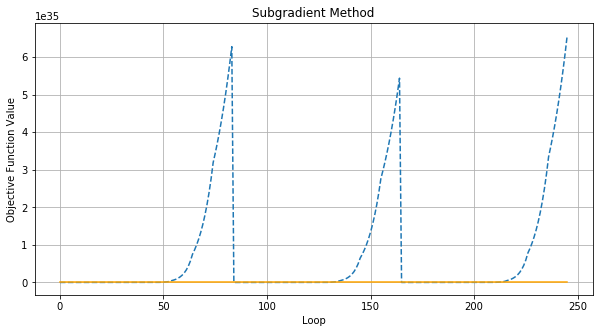

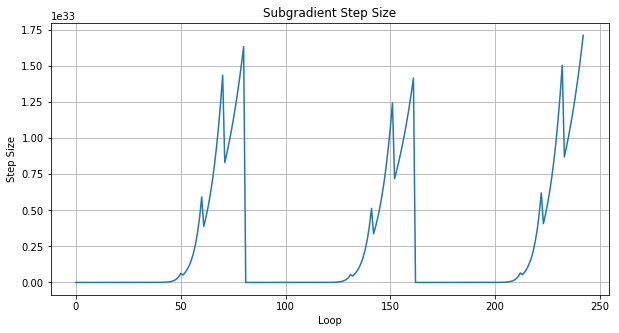

In [116]:
# subgradient bound improvement
plt.figure(1)
#plt.subplot(411)
z_subgradient = Log.d['z_lr']
z_ip = Log.d["z_ip"]
plt.plot(z_subgradient, linestyle='dashed')
plt.plot(z_ip, color='orange')
plt.xlabel('Loop')
plt.ylabel('Objective Function Value')
plt.title('Subgradient Method')
plt.grid(True)
#plt.show()

# subgradient step size
plt.figure(2)
#plt.subplot(412)
step_size = Log.d["step_size"]
plt.plot(step_size)
plt.xlabel('Loop')
plt.ylabel('Step Size')
plt.title('Subgradient Step Size')
plt.grid(True)

plt.show()